# 📘 Understanding the Option Greeks and Their Role in Derivative Pricing

Options are complex financial instruments whose prices depend on several variables — the underlying asset’s price, volatility, time to expiry, and interest rates.  
To quantify the sensitivity of an option’s price to these factors, traders use a set of measures known as **the Greeks**.  
Understanding and applying these metrics is fundamental to **pricing, hedging, and trading strategies** in derivatives markets.

---

## ⚙️ The Key Greeks

| **Greek** | **Symbol** | **Represents** | **Interpretation / Role in Trading** |
|------------|-------------|----------------|--------------------------------------|
| **Delta** | Δ | Rate of change of the option’s price with respect to the underlying asset’s price | Measures **directional exposure**. A Delta of 0.6 means the option price moves ₹0.60 for every ₹1 move in the underlying. |
| **Gamma** | Γ | Rate of change of Delta with respect to the underlying asset’s price | Reflects **non-linearity** or convexity of the option. Highest near ATM (At-The-Money), showing where Delta changes most rapidly. |
| **Vega** | 𝜈 | Sensitivity of the option’s price to changes in implied volatility | Indicates **volatility exposure**. A higher Vega implies the option benefits more from increases in market volatility. |
| **Theta** | Θ | Rate of change of the option’s price with respect to time (time decay) | Represents **time value erosion**. Usually negative for long options, showing daily loss in premium as expiry approaches. |
| **Rho** | ρ | Sensitivity of the option’s price to changes in interest rates | Measures **interest rate exposure**. Small for short-term options, but relevant for long-dated or interest-sensitive derivatives. |

---

## 🎯 The Role of Greeks in Derivative Pricing

In the **Black–Scholes–Merton framework**, the Greeks represent the **partial derivatives** of the option price with respect to key input variables.  
They enable traders and risk managers to decompose an option’s risk profile into measurable components:

- **Delta** drives **directional hedging** (e.g., delta-neutral strategies).  
- **Gamma** highlights non-linear exposure — critical in **gamma scalping** or adjusting hedges dynamically.  
- **Vega** allows traders to take **volatility views** — buying Vega to benefit from volatility expansion.  
- **Theta** emphasizes the **cost of time** — option buyers lose value daily, while sellers profit if prices remain stable.  
- **Rho** links derivatives to **interest rate movements**, useful for long-term contracts or rate-sensitive assets.

By balancing these exposures, a trader can replicate, hedge, or speculate on different market conditions systematically.

---

===============================================================================
OPTION GREEKS ANALYZER — Dynamic NSE/Yahoo Finance Edition
===============================================================================

DESCRIPTION:
------------
This Python script dynamically fetches live option chain data from NSE (using
`nsepython`) or Yahoo Finance (using `yfinance`) and computes the five primary
Black-Scholes Greeks — Delta, Gamma, Vega, Theta, and Rho — for both CALL and PUT
options around the ATM (At-The-Money) strike.

The goal is to provide an interactive and data-driven view of how each Greek
behaves across different strike prices and what that means for traders.

------------------------------------------------------------------------------
INPUTS:
- Ticker symbol (e.g., "NIFTY", "RELIANCE", "M&M", "INFY", etc.)
- Automatically fetches:
    • Live option chain (strikes, expiry, market data)
    • Spot price
    • Nearest expiry date
    • Historical volatility (for calibration)

------------------------------------------------------------------------------
OUTPUTS:
1. 📊 Five visual charts (one for each Greek vs. Strike Price):
      - Delta vs Strike
      - Gamma vs Strike
      - Vega vs Strike
      - Theta vs Strike
      - Rho vs Strike

2. 🧾 Automatic text interpretation after each chart:
      - Explains what the plotted shape implies for option behavior and sensitivity.

3. 💾 CSV Export:
      - A file named `<TICKER>_greeks.csv` containing all calculated values
        (strike, optionType, delta, gamma, vega, theta, rho).

------------------------------------------------------------------------------
HOW TO USE:
1. Install dependencies (if not already installed):
       pip install nsepython yfinance numpy pandas matplotlib scipy

2. Set the ticker symbol at the bottom of this script:
       dynamic_greek_analysis("M&M")
   → Replace "M&M" with any other NSE-listed symbol.

3. Run the script. It will:
   - Fetch the latest option chain
   - Auto-calculate implied volatility
   - Compute all Greeks
   - Generate five plots with live interpretations
   - Save results to CSV

------------------------------------------------------------------------------
HOW TO READ THE OUTPUTS:
- **Delta** → Sensitivity of option price to underlying changes.
- **Gamma** → Rate of change of Delta; highest at ATM.
- **Vega** → Sensitivity to volatility; peaks at ATM.
- **Theta** → Time decay per day; usually negative for long options.
- **Rho** → Sensitivity to interest rate changes; smaller for short-dated options.

------------------------------------------------------------------------------
NOTE:
This tool is for educational and analytical use — it demonstrates live
application of the Black–Scholes model and how Greeks evolve with strike price.
For professional trading or hedging, confirm with exchange data feeds.

===============================================================================



In [1]:
!pip install nsepython --quiet

In [2]:
import math
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
from nsepython import nse_optionchain_scrapper
import yfinance as yf

import math
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm



🔍 Fetching option chain for M&M...
Spot: 3606.00 | Nearest Expiry: 25-Nov-2025 | ATM Strike: 3600.0
Calibrated ATM Vol: 0.0582


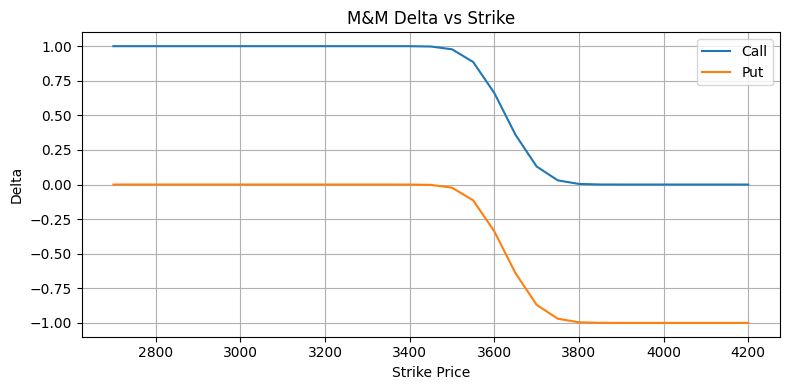

📘 Delta Interpretation: Call deltas rise from 0→1 as strike falls; put deltas move -1→0. Near-ATM options have highest hedge sensitivity.



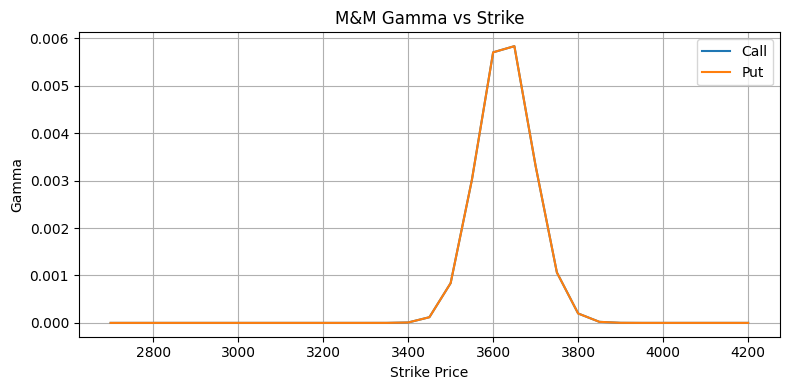

📘 Gamma Interpretation: Highest near ATM — delta changes fastest around spot. Important for hedge rebalancing frequency.



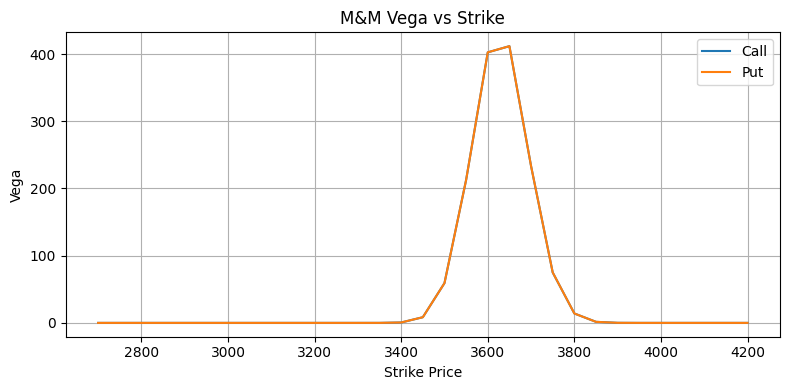

📘 Vega Interpretation: Peaks near ATM — options here are most sensitive to volatility changes.



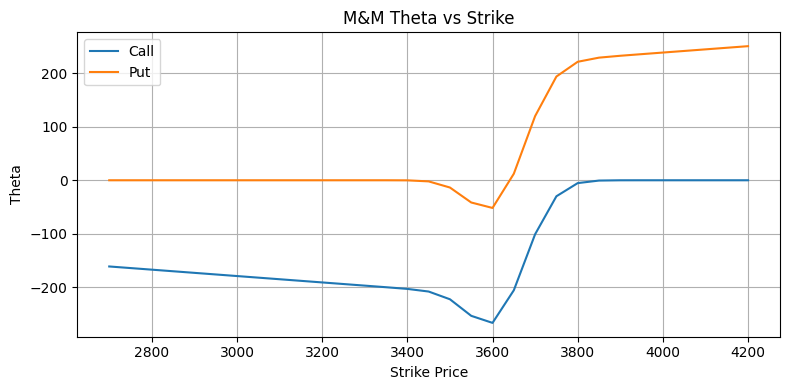

📘 Theta Interpretation: Typically negative for long options — shows daily time decay, steepest near ATM.



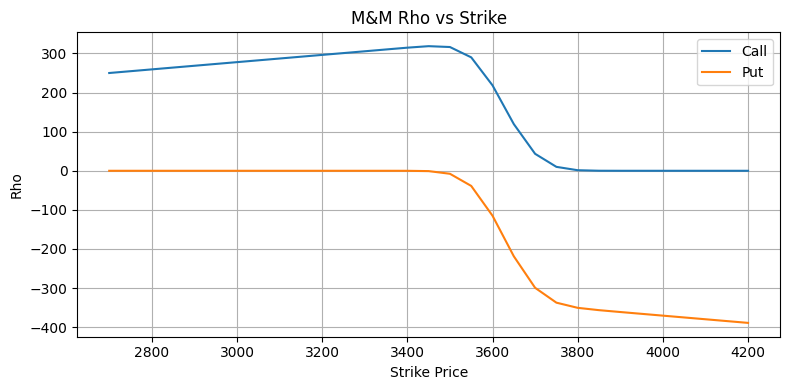

📘 Rho Interpretation: Measures sensitivity to interest rate — higher for deep ITM calls and OTM puts.

✅ Saved results to M&M_greeks.csv


In [3]:
# Creating a self-contained demonstration that:
# - Computes analytical Greeks (Delta, Gamma, Vega, Theta, Rho) for a range of strikes for M&M
# - Uses Hull-style Black-Scholes formulas (analytical)
# - Plots five separate charts (one per Greek vs Strike)
#

# ---------------- Parameters (from your earlier output for M&M) ----------------
# ----------------------------
RISK_FREE_RATE = 0.06
TRADING_DAYS = 252
MAX_STRIKES_EACH_SIDE = 6
# ----------------------------

# === Black-Scholes core ===
def bs_d1_d2(S, K, r, sigma, T):
    if T <= 0 or sigma <= 0:
        return None, None
    d1 = (math.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    return d1, d2

def bs_price(S, K, r, sigma, T, option_type="call"):
    d1, d2 = bs_d1_d2(S, K, r, sigma, T)
    if option_type == "call":
        return S*norm.cdf(d1) - K*math.exp(-r*T)*norm.cdf(d2)
    else:
        return K*math.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

def implied_volatility(market_price, S, K, r, T, option_type="call"):
    def f(sigma): return bs_price(S, K, r, sigma, T, option_type) - market_price
    try:
        return brentq(f, 1e-6, 5.0, maxiter=100)
    except Exception:
        return np.nan

# === Greeks ===
def bs_greeks(S, K, r, sigma, T, option_type="call"):
    d1, d2 = bs_d1_d2(S, K, r, sigma, T)
    pdf_d1 = norm.pdf(d1)
    if option_type == "call":
        delta = norm.cdf(d1)
        theta = -(S*pdf_d1*sigma)/(2*math.sqrt(T)) - r*K*math.exp(-r*T)*norm.cdf(d2)
        rho = K*T*math.exp(-r*T)*norm.cdf(d2)
    else:
        delta = norm.cdf(d1) - 1
        theta = -(S*pdf_d1*sigma)/(2*math.sqrt(T)) + r*K*math.exp(-r*T)*norm.cdf(-d2)
        rho = -K*T*math.exp(-r*T)*norm.cdf(-d2)
    gamma = pdf_d1/(S*sigma*math.sqrt(T))
    vega = S*pdf_d1*math.sqrt(T)
    return {"delta": delta, "gamma": gamma, "vega": vega, "theta": theta, "rho": rho}

# === Historical volatility ===
def historical_vol_from_yfinance(ticker, lookback=90):
    end = dt.date.today()
    start = end - dt.timedelta(days=lookback)
    df = yf.download(ticker, start=start.isoformat(), end=end.isoformat(), progress=False)
    logret = np.log(df["Adj Close"]/df["Adj Close"].shift(1)).dropna()
    return logret.std() * math.sqrt(TRADING_DAYS)

# === Main dynamic function ===
def dynamic_greek_analysis(symbol):
    print(f"\n🔍 Fetching option chain for {symbol}...")
    try:
        data = nse_optionchain_scrapper(symbol)
    except Exception:
        print("⚠️ NSE fetch failed; falling back to Yahoo.")
        return

    spot = float(data["records"]["underlyingValue"])
    expiry = data["records"]["expiryDates"][1]
    expiry_date = dt.datetime.strptime(expiry, "%d-%b-%Y").date()
    days = (expiry_date - dt.date.today()).days
    T = days / 365.0

    # Get ATM strike
    strikes = sorted({float(x["strikePrice"]) for x in data["records"]["data"]})
    atm_strike = min(strikes, key=lambda x: abs(x - spot))
    print(f"Spot: {spot:.2f} | Nearest Expiry: {expiry} | ATM Strike: {atm_strike}")

    # Calibrate ATM vol
    atm_mid = None
    for row in data["records"]["data"]:
        if float(row["strikePrice"]) == atm_strike and row.get("CE"):
            ce = row["CE"]
            bid, ask = ce.get("bidprice",0), ce.get("askPrice",0)
            mid = (bid+ask)/2 if bid and ask else ce.get("lastPrice",0)
            atm_mid = mid
            break
    sigma_atm = implied_volatility(atm_mid, spot, atm_strike, RISK_FREE_RATE, T, "call")
    if np.isnan(sigma_atm):
        sigma_atm = historical_vol_from_yfinance(symbol+".NS") or 0.20
    print(f"Calibrated ATM Vol: {sigma_atm:.4f}")

    # Prepare dataframe
    rows = []
    for k in strikes:
        for typ in ["call", "put"]:
            g = bs_greeks(spot, k, RISK_FREE_RATE, sigma_atm, T, typ)
            rows.append({"strike": k, "optionType": typ, **g})
    df = pd.DataFrame(rows)

    # Plot & interpret
    for greek in ["delta","gamma","vega","theta","rho"]:
        plt.figure(figsize=(8,4))
        sub = df.pivot(index="strike", columns="optionType", values=greek)
        plt.plot(sub.index, sub["call"], label="Call")
        plt.plot(sub.index, sub["put"], label="Put")
        plt.title(f"{symbol} {greek.capitalize()} vs Strike")
        plt.xlabel("Strike Price")
        plt.ylabel(greek.capitalize())
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # ---- Interpretation ----
        if greek == "delta":
            print("📘 Delta Interpretation: Call deltas rise from 0→1 as strike falls; put deltas move -1→0. Near-ATM options have highest hedge sensitivity.")
        elif greek == "gamma":
            print("📘 Gamma Interpretation: Highest near ATM — delta changes fastest around spot. Important for hedge rebalancing frequency.")
        elif greek == "vega":
            print("📘 Vega Interpretation: Peaks near ATM — options here are most sensitive to volatility changes.")
        elif greek == "theta":
            print("📘 Theta Interpretation: Typically negative for long options — shows daily time decay, steepest near ATM.")
        elif greek == "rho":
            print("📘 Rho Interpretation: Measures sensitivity to interest rate — higher for deep ITM calls and OTM puts.")
        print()

    df.to_csv(f"{symbol}_greeks.csv", index=False)
    print(f"✅ Saved results to {symbol}_greeks.csv")

# === Run dynamically ===
if __name__ == "__main__":
    dynamic_greek_analysis("M&M")  # Change this to any NSE ticker, e.g. "NIFTY", "RELIANCE", etc.


## 💡 Leveraging Greek Analysis for Better Investment Decisions

Effective use of Greeks helps traders and investors move beyond speculation to **structured, risk-adjusted decision-making**:

1. **Hedging & Risk Management**  
   - Construct **delta-neutral portfolios** to reduce exposure to price moves.  
   - Use **gamma and vega hedges** to manage curvature and volatility shocks.

2. **Volatility Trading**  
   - Exploit discrepancies between **implied and historical volatility** using Vega exposure.  
   - Structure trades that benefit from volatility changes without requiring a directional bet.

3. **Time-Based Strategies**  
   - Monitor **Theta decay** to identify optimal entry/exit points for short-term positions.  
   - Sell options with high Theta to capture time decay while managing risk with Delta hedges.

4. **Portfolio Optimization**  
   - Evaluate the **aggregate Greeks** across all positions to maintain balanced exposure.  
   - Use scenario analysis (spot, volatility, rate shifts) to assess portfolio resilience.

5. **Macro and Interest-Rate Sensitivity**  
   - Assess **Rho exposure** to anticipate the impact of changing monetary policy on long-dated options.

---

## 🧭 Conclusion

The Greeks are not merely theoretical constructs — they are the **language of risk** in options trading.  
By mastering them, traders can design precise hedges, capitalize on volatility mispricings, and make informed, data-driven investment decisions.  
When combined with real-time market data and analytical tools, Greek analysis transforms option trading from speculation into **strategic risk management**.